In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
tmin_2017, tavg_2017, tmax_2017 = calc_temps('2017-08-01', '2017-08-07')[0]
calc_temps('2017-08-01', '2017-08-07')

[(72.0, 79.25, 83.0)]

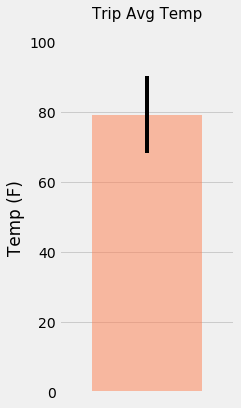

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2.8,6))

plt.bar(range(3), [0, tavg_2017, 0], width=4.5, yerr=[0, tmax_2017-tmin_2017, 0],
        alpha=0.5, color='coral')

plt.xticks(range(3), '')
plt.ylim(0, 100)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp', fontsize=15, y=1.05)
plt.grid(axis='x')

plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]

results = session.query(*sel).filter(Measurement.station == Station.station).\
                              filter(Measurement.date >= '2017-08-01').\
                              filter(Measurement.date <= '2017-08-07').\
                              group_by(Measurement.station,
                                       Station.name,
                                       Station.latitude,
                                       Station.longitude,
                                       Station.elevation).\
                              order_by(func.sum(Measurement.prcp).desc()).all()

results

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.36),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.22),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# Calculate the daily normals for your trip,
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
start_split = start_date.split('-')
end_split = end_date.split('-')
start_dt = dt.date(int(start_split[0]), int(start_split[1]), int(start_split[2]))
end_dt = dt.date(int(end_split[0]), int(end_split[1]), int(end_split[2]))

dates_dt = []
span = end_dt - start_dt

for day in range(span.days + 1):
    dates_dt.append(start_dt + dt.timedelta(days=day))

# Strip off the year and save a list of strings in the format %m-%d
dates_string = []

for date_dt in dates_dt:
    month = date_dt.strftime('%m')
    day = date_dt.strftime('%d')
    dates_string.append(f'{month}-{day}')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [daily_normals(date_string) for date_string in dates_string]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin = [round(result[0][0], 2) for result in normals]
tavg = [round(result[0][1], 2) for result in normals]
tmax = [round(result[0][2], 2) for result in normals]

tobs_df = pd.DataFrame({'date': dates_dt,
                        'min temperature': tmin,
                        'avg temperature': tavg,
                        'max temperature': tmax}).\
                        set_index('date')

tobs_df

,min temperature,avg temperature,max temperature
date,,,
2017-08-01,67.0,75.54,83.0
2017-08-02,68.0,75.60,84.0
2017-08-03,70.0,76.61,85.0
2017-08-04,69.0,76.71,84.0
2017-08-05,69.0,76.15,82.0
2017-08-06,67.0,76.25,83.0
2017-08-07,71.0,77.16,83.0


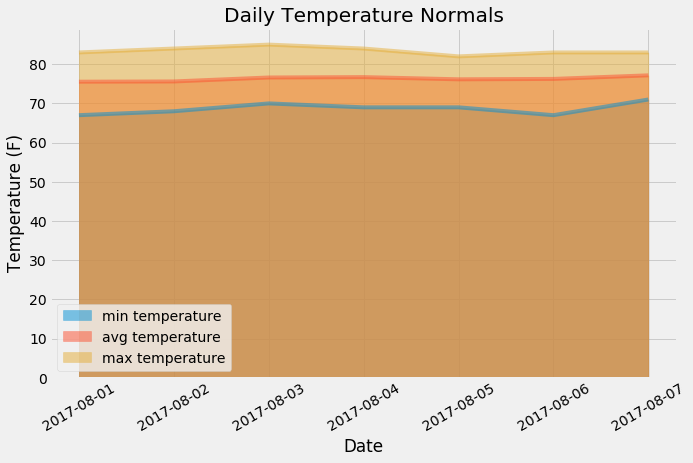

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
tobs_df.plot.area(stacked=False, figsize=(10,6), rot=30,
                  xlabel='Date', ylabel='Temperature (F)',
                  title='Daily Temperature Normals')

plt.show()

## Close Session

In [17]:
session.close()